In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline
import random
import math

In [2]:
import torchvision
import torchvision.transforms as transforms

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

Device available now: cuda


In [4]:
image_transforms = transforms.Compose(
         [transforms.ToTensor(),
         transforms.CenterCrop(28),
         transforms.Normalize((0.5), (0.5))]
)

In [5]:
batchsize = 64
rowsize = 28
colsize = 28
inchannels = 1
fc_size = 800
no_classes = 10
epochs = 10 


In [6]:

train_ioc = []
test_ioc = 0
train_nn = []
# noise = 40
test_nn = 0

In [7]:
my_transform = transforms.Compose([transforms.ToTensor()])

train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform = image_transforms)
test = torchvision.datasets.MNIST(root='./data', train=False, transform = image_transforms)



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
traindata = torch.utils.data.DataLoader(train,batch_size=batchsize, shuffle=True)
testdata = torch.utils.data.DataLoader(test,batch_size=batchsize, shuffle=False)

In [9]:
# for i,data in enumerate(traindata):
#   data[0] , data[1]
#   for j in range(len(data)):
#     data[1][j] = random.randint(0, 9)

In [10]:
class IOC_MLP(nn.Module):
  def __init__(self,rowsize,colsize,fc_size,inchannels,no_classes):
    super(IOC_MLP, self).__init__()
    self.fc1 = nn.Linear(rowsize*colsize*inchannels,fc_size)
    self.batchnorm1 = nn.BatchNorm1d(fc_size)
    self.fc2 = nn.Linear(fc_size,fc_size)
    self.batchnorm2 = nn.BatchNorm1d(fc_size)
    self.fc3 = nn.Linear(fc_size,fc_size)
    self.batchnorm3 = nn.BatchNorm1d(fc_size)
    self.fc4 = nn.Linear(fc_size,no_classes)


  def forward(self, x):
    x = torch.flatten(x,1)
    x = x.view(-1, rowsize*colsize*inchannels)
    x = F.elu(self.fc1(x))
    x = self.batchnorm1(x)
    x = F.elu(self.fc2(x))
    x = self.batchnorm2(x)
    x = F.elu(self.fc3(x))
    x = self.batchnorm3(x)
    return x

In [11]:
class NN(nn.Module):
  def __init__(self,rowsize,colsize,fc_size,inchannels,no_classes):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(rowsize*colsize*inchannels,fc_size)
    self.batchnorm1 = nn.BatchNorm1d(fc_size)
    self.fc2 = nn.Linear(fc_size,fc_size)
    self.batchnorm2 = nn.BatchNorm1d(fc_size)
    self.fc3 = nn.Linear(fc_size,fc_size)
    self.batchnorm3 = nn.BatchNorm1d(fc_size)
    self.fc4 = nn.Linear(fc_size,no_classes)


  def forward(self, x):
    # x = torch.flatten(x,1)
    x = x.view(-1, rowsize*colsize*inchannels)
    x = F.relu(self.fc1(x))
    x = self.batchnorm1(x)
    x = F.relu(self.fc2(x))
    x = self.batchnorm2(x)
    x = F.relu(self.fc3(x))
    x = self.batchnorm3(x)
    return x

In [12]:
ioc_model = IOC_MLP(rowsize,colsize,fc_size,inchannels,no_classes).to(device)
nn_model = NN(rowsize,colsize,fc_size,inchannels,no_classes).to(device)

In [13]:
ioc_optimizer = torch.optim.Adam(ioc_model.parameters(),lr= 0.0001)
nn_optimizer = torch.optim.Adam(nn_model.parameters(),lr= 0.0001)
criterion = nn.CrossEntropyLoss().to(device)

In [14]:

for i in range(epochs):
  Loss = 0
  num_correct=0
  tot = 0
  for i,data in enumerate(traindata):
    # iterating through every batch
    x_data = data[0].to(device)
    labels = data[1].to(device)
    ioc_optimizer.zero_grad()
    outputs = ioc_model(x_data)
    _, pred = torch.max(outputs.data, 1)
    num_correct += (pred == labels).sum().item()
    tot += labels.size(0)
    loss = criterion(outputs, labels)
    loss.backward()
    ioc_optimizer.step()
    Loss += loss
    for w in ioc_model.parameters():
      p = w
      torch.where(w > 0, w, torch.exp(p))
  train_ioc.append(num_correct/tot)    
  # print("Accuracy for exponentiation on negative weights : ",num_correct/tot)
  # print("Loss for exponentiation on negative weights : ",loss.item())
  

In [15]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testdata:
        images = images.to(device)
        labels = labels.to(device)
        outputs = ioc_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_ioc = correct/total
    print("Test Accuracy for IOC Architecture : ",100 * correct / total)



Test Accuracy for IOC Architecture :  97.79


In [16]:

for i in range(epochs):
  Loss = 0
  num_correct=0
  tot = 0
  for i,data in enumerate(traindata):
    # iterating through every batch
    x_data = data[0].to(device)
    labels = data[1].to(device)
    nn_optimizer.zero_grad()
    outputs = nn_model(x_data)
    _, pred = torch.max(outputs.data, 1)
    num_correct += (pred == labels).sum().item()
    tot += labels.size(0)
    loss = criterion(outputs, labels)
    loss.backward()
    nn_optimizer.step()
    Loss += loss
  train_nn.append(num_correct/tot)    
  # print("Accuracy for exponentiation on negative weights : ",num_correct/tot)
  # print("Loss for exponentiation on negative weights : ",loss.item())
  

In [17]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testdata:
        images = images.to(device)
        labels = labels.to(device)
        outputs = nn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_nn = correct/total
    print("Test Accuracy for NN Architecture : ",100 * correct / total)



Test Accuracy for NN Architecture :  97.73


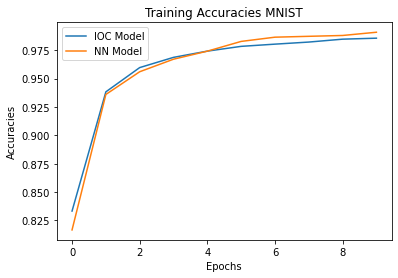

In [18]:
import matplotlib.pyplot as plt
epoch_numbers = np.arange(0,epochs,1)
plt.title("Training Accuracies MNIST")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.plot(epoch_numbers,train_ioc,label='IOC Model')
plt.plot(epoch_numbers,train_nn,label='NN Model')     
plt.legend()
plt.show()  

In [20]:
print("Generalization Gap for NN Model",(train_nn[len(train_nn)-1]*100)-(test_nn*100))
print("Generalization Gap for IOC Model",(train_ioc[len(train_ioc)-1]*100)-(test_ioc*100))

Generalization Gap for NN Model 1.3466666666666782
Generalization Gap for IOC Model 0.7633333333333496
